# Buffer Layer Optimization
#### By: John Healey

## Introduction

We are studying the effect of using different kinds of PEDOT in the PEDOT:PSS buffer layer on the device's photon absorption and internal optical electrical field distribution. We will also determine the ITO thickness that optimizes these parameters.

We will be using Transfer Matrix Formalism (TMF) to evaluate these properties, which is explained [here](https://aip.scitation.org/doi/abs/10.1063/1.370757), and summarized below.

## Theory behind TMF

### Interface Matrices

Each interface in the structure (between layers j and k) can be described by an interface matrix of the form:

$I_{jk} = \frac{1}{t_{jk}} \begin{bmatrix}1 & r_{jk}\\r_{jk} & 1\end{bmatrix}$

where $r_{jk}$ and $t_{jk}$ are the Fresnel complex *reflection* and *transmission* coefficients at interface jk.

These coefficients are given by:

$r_{jk} = \frac{q_j - q_k}{q_j + q_k},$

$t_{jk} = \frac{2 q_j}{q_j + q_k}$

where

$q_j = [\tilde{n}_j^2 - \eta_0^2 sin \phi_0]^\frac{1}{2}$

We assume that $\phi_0$ is 0, so $q_j$ is simplified to $\tilde{n}_j$ - the complex index of refraction of layer j, which is determined experimentally:

$q_j = \tilde{n}_j$.

### Layer Matrices

The layer matrix describing the propagation through layer j is given by:

$L_j = \begin{bmatrix}e^{-i \xi_j d_j} & 0\\0 & e^{i \xi_j d_j}\end{bmatrix}$

where

$\xi_j = \frac{2 \pi}{\lambda} q_j$

and $\xi_j d_j$ is the *layer phase thickness*, corresponding to the phase change the wave experiences as it traverses layer j.

### System Transfer Matrix

By using the interface and layer matrices, the total system transfer matrix (scattering matrix) S can be written:

$S = \begin{bmatrix}S_{11} & S_{12}\\S_{21} & S_{22}\end{bmatrix} = (\prod_{v=1}^{m} I_{(v-1)v} L_v) I_{m(m+1)}$

This matrix relates the electric field at the ambient side and susbstrate side (Aluminum cathode - layer m+1) by:

$\begin{bmatrix}E_0^+\\E_0^-\end{bmatrix} = S \begin{bmatrix}E_{m+1}^+\\E_{m+1}^-\end{bmatrix}$

where the optical electric field at any point in the system is resolved into two components: one component propagating in the positive x direction and one in the negative x direction, which at a position x in layer j are denoted $E_j^+ (x)$ and $E_j^- (x)$

For the total layered structure, the resulting complex reflection and transmission coefficients can be expressed by using
the matrix elements of the total system transfer matrix:

$r = \frac{E_0^-}{E_0^+} = \frac{S_{21}}{S_{11}}, $

$t = \frac{E_{m+1}^+}{E_0^+} = \frac{1}{S_{11}}$.

### Calculating Internal Electric Field

In order to calculate the internal electric field in layer j, the layers can be divided into two subsets: one subset to the left of j which will be represented by $S_j'$, and one subset to the right of j which we'll represent with $S_j''$.

The total system transfer matrix can then be written as

$S = S_j' L_j S_j''$

The partial system transfer matrix for the layers left of j is equal to

$S_j' = \begin{bmatrix}S_{j11}' & S_{j12}'\\S_{j21}' & S_{j22}'\end{bmatrix} = (\prod_{v=1}^{j-1} I_{(v-1)v} L_v) I_{(j-1)j}$,

and relates the electric field at the ambient to that at the left boundary of j - that is, at (j-1)j - by:

$\begin{bmatrix}E_0^+\\E_0^-\end{bmatrix} = S_j' \begin{bmatrix}E_j'^+\\E_j'^-\end{bmatrix}$.

For the layers right of j, the matrix is

$S_j'' = \begin{bmatrix}S_{j11}'' & S_{j12}''\\S_{j21}'' & S_{j22}''\end{bmatrix} = (\prod_{v=j+1}^{m} I_{(v-1)v} L_v) I_{m(m+1)}$,

which relates the electric field at the right boundary of j - that is, at j(j+1) - to that at the substsrate by:

$\begin{bmatrix}E_j''^+\\E_j''^-\end{bmatrix} = S_j'' \begin{bmatrix}E_{m+1}^+\\E_{m+1}^-\end{bmatrix}$.

Note that the electric field relations given here will not be used in the final calculation, and are only provided to give a better understanding of the scattering matrices.

The expression for the total electric field in an arbitrary plane $j$ at distance $x$ from the left boundary of j is:

$$
E_j(x) = \frac{S_{j11}'' \cdot e^{-i \xi_j (d_j - x)} + S_{j21}'' \cdot e^{i \xi_j (d_j - x)}}
{S_{j11}' S_{j11}'' \cdot e^{-i \xi_j d_j} + S_{j12}' S_{j21}'' \cdot e^{i \xi_j d_j}}
E_0^+,
$$

where $0 \le x \le d$.

## Calculation

### Setting up constants

In [1]:
import numpy as np
from scipy import constants
from matplotlib import pyplot as plt
import math
import cmath

wavelength = 632.8 # nm
E_0 = constants.h * constants.c / wavelength # energy of the light in the ambient
m = 3 # no. of layers between ambient and substrate (Al cathode)

#### Interface Matrices

In [2]:
# Determined optical properties of [Ambient, ITO, Buffer, Active, Cathode (substrate)]
eta = np.array([1.0003, 1.736, 1.44916, 1.5, 1.37166]) # refractive indices
k = np.array([0, 0.01178, 0.05326, 0.1192994, 7.60477]) # extinction coefficients
n = eta + 1j*k # complex indices of refraction
q = n # since we are assuming that the angle of incidence is 0

# Fresnel complex coefficients
# t[0] corresponds to t_01 in the above theory
t = [] # transmission
r = [] # reflection

for j in range(len(q) - 1):
    k = j+1
    t_jk = (2 * q[j]) / (q[j] + q[k])
    r_jk = (q[j] - q[k]) / (q[j] + q[k])
    t.append(t_jk)
    r.append(r_jk)

t = np.array(t)
r = np.array(r)

# The interface matrices will be calculated inline using these values rather than creating them all now in a 3-D array.

#### Layer Matrices

In [3]:
# Layer phase thicknesses of [Ambient (for consistent indices), ITO, Buffer, Active, Cathode]
d = [float("inf"), 130, 50, 110, 50]
xi = q * (2 * math.pi / wavelength)
xi[0] = float("inf") # ensure that both d and xi are infinite for the ambient, since they shouldn't be used

# The layer matrices will be calculated inline using these values rather than creating them all now in a 3-D array.

#### System Transfer Matrix

In [4]:
# Returns the scattering matrix corresponding to the given layers. Defaults to the matrix for the System.
def scattering_matrix(start_layer=1, stop_layer=m, trans=t, refl=r, thick=d):
    prod = np.identity(2) # initial value of cumulative product
    for v in range(start_layer, stop_layer+1):
        # interface matrix I_(v-1)v
        t_jk = trans[v-1]
        r_jk = refl[v-1]
        I_v = (1 / t_jk) * np.array([
                                        [1, r_jk], 
                                        [r_jk, 1]
                                    ]) 

        # layer matrix L_v
        phase_thickness = xi[v] * thick[v]
        L_v = np.array([
                            [cmath.exp(-1j*phase_thickness), 0],
                            [0, cmath.exp(1j*phase_thickness)]
                       ])

        inner_prod = np.matmul(I_v, L_v)

        prod = np.matmul(prod, inner_prod)

    outer_interface = (1 / trans[stop_layer]) * np.array([
                                                        [1, refl[stop_layer]],
                                                        [refl[stop_layer], 1]
                                                     ])
    return np.matmul(prod, outer_interface)

In [5]:
S = scattering_matrix()
print(S)

[[-3.35074142+0.8158646j   3.16830298+1.00466937j]
 [-1.24115544+0.41403532j  1.36473337-1.95595221j]]


### Optimizing the internal optical electric field

Here, we calculate the distribution of the normalized modulus squared of the incident optical electric field of the device using two different buffer layers.

In [6]:
# Returns the electric field at point x in layer j, given the partial scattering matrices.
def electric_field(S_left, S_right, j, x, thick=d):
    exp_1 = cmath.exp(-1j*xi[j] * (thick[j]-x))
    exp_2 = cmath.exp(1j*xi[j] * (thick[j]-x))
    numerator = (S_right[0][0] * exp_1) + (S_right[1][0] * exp_2)

    exp_3 = cmath.exp(-1j*xi[j]*thick[j])
    exp_4 = cmath.exp(1j*xi[j]*thick[j])
    denominator = (S_left[0][0] * S_right[0][0] * exp_3) + (S_left[0][1] * S_right[1][0] * exp_4)

    return (numerator/denominator) * E_0

#### Modified buffer layer parameters

In [7]:
# Determined optical properties of [Ambient, ITO, Modified Buffer, Active, Cathode (substrate)]
eta_mod = np.array([1.0003, 1.736, 1.2, 1.5, 1.37166]) # refractive indices
k_mod = np.array([0, 0.01178, 0.05, 0.1192994, 7.60477]) # extinction coefficients
n_mod = eta_mod + 1j*k_mod # complex indices of refraction
q_mod = n_mod # since we are assuming that the angle of incidence is 0

# Fresnel complex coefficients
# t[0] corresponds to t_01 in the above theory
t_mod = [] # transmission
r_mod = [] # reflection

for j in range(len(q_mod) - 1):
    k = j+1
    t_jk = (2 * q_mod[j]) / (q_mod[j] + q_mod[k])
    r_jk = (q_mod[j] - q_mod[k]) / (q_mod[j] + q_mod[k])
    t_mod.append(t_jk)
    r_mod.append(r_jk)

t_mod = np.array(t_mod)
r_mod = np.array(r_mod)

#### Electric field comparison

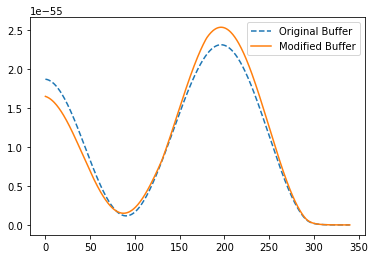

In [8]:
E = []
E_mod = []
position = []
current_position = 0
for j in range(1, m+2):
    # To the left of j:
    S_left = scattering_matrix(1, j-1)
    S_left_mod = scattering_matrix(1, j-1, trans=t_mod, refl=r_mod)

    # To the right of j:
    S_right = scattering_matrix(j+1, m)
    S_right_mod = scattering_matrix(j+1, m, trans=t_mod, refl=r_mod)

    # Electric field in j:
    x_j = np.linspace(0, d[j], 200) # values for position in this layer
    position.extend(x_j + current_position)
    current_position += d[j]
    for x in x_j:
        E.append(electric_field(S_left, S_right, j, x))
        E_mod.append(electric_field(S_left_mod, S_right_mod, j, x))
    
E_norm = np.array(np.abs(E)**2)
E_mod_norm = np.array(np.abs(E_mod)**2)
plt.plot(position, E_norm, label="Original Buffer", linestyle='--')
plt.plot(position, E_mod_norm, label="Modified Buffer")
plt.legend()
plt.show()

### Further optimizing the internal optical electric field

Here, we once again calculate the normalized modulus squared of the incident optical electric field of the device, this time using ITO of various thicknesses.

0
100
150
260


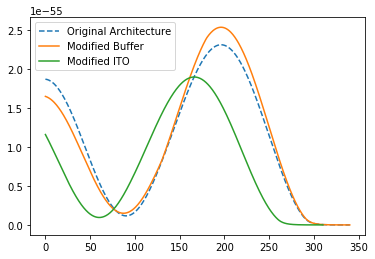

In [10]:
d_mod = [-1, 100, 50, 110, 50]
E_ito_mod = []
position_ito_mod = []
current_position = 0
for j in range(1, m+2):
    print(current_position)
    # To the left of j:
    S_left = scattering_matrix(1, j-1, thick=d_mod)

    # To the right of j:
    S_right = scattering_matrix(j+1, m, thick=d_mod)

    # Electric field in j:
    x_j = np.linspace(0, d_mod[j], 200) # values for position in this layer
    position_ito_mod.extend(x_j + current_position)
    current_position += d_mod[j]
    for x in x_j:
        E_ito_mod.append(electric_field(S_left, S_right, j, x, thick=d_mod))
    
E_ito_mod_norm = np.array(np.abs(E_ito_mod)**2)
plt.plot(position, E_norm, label="Original Architecture", linestyle='--')
plt.plot(position, E_mod_norm, label="Modified Buffer")
plt.plot(position_ito_mod, E_ito_mod_norm, label="Modified ITO")
plt.legend()
plt.show()

### Optimizing photon absorption

Here, we calculate the absorption and reflectance of the device using various ITO thicknesses.